In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

In [4]:
X_train = pd.read_csv("x_train_final.csv")
X_train = X_train[["train", "gare", "date", "arret", "p2q0", "p3q0", "p4q0", "p0q2", "p0q3", "p0q4"]]
y_train = pd.read_csv("y_train_final_j5KGWWK.csv")
y_train = y_train[["p0q0"]]

# Clustering x_train Based on Selected Features

In [9]:
df = X_train
df = df.drop_duplicates()

In [10]:
clustering_features = ['p2q0', 'p3q0', 'p4q0', 'p0q2', 'p0q3', 'p0q4']
X = df[clustering_features].copy()
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Set number of clusters
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['cluster'] = cluster_labels

In [12]:
print("Cluster element counts:")
print(df['cluster'].value_counts())

Cluster element counts:
cluster
0    666215
1      1049
Name: count, dtype: int64


In [13]:
# We'll reduce the clustering features to two principal components so that we can visualize the clusters.

# %% [code]
pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_scaled)
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]

# Print explained variance to see how much variance is captured
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

Explained variance ratio (PC1, PC2): [0.28560967 0.19489716 0.17290671 0.1544471  0.13345294 0.05868641]


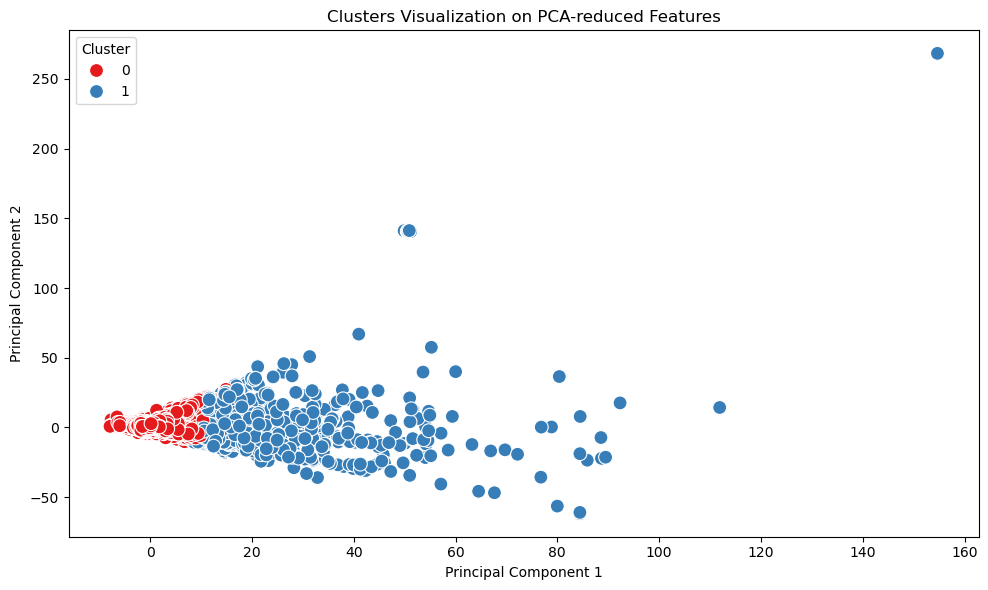

In [19]:
# Plot clusters based on PCA components
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca_one', y='pca_two', hue='cluster', palette='Set1', s=100)
plt.title('Clusters Visualization on PCA-reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

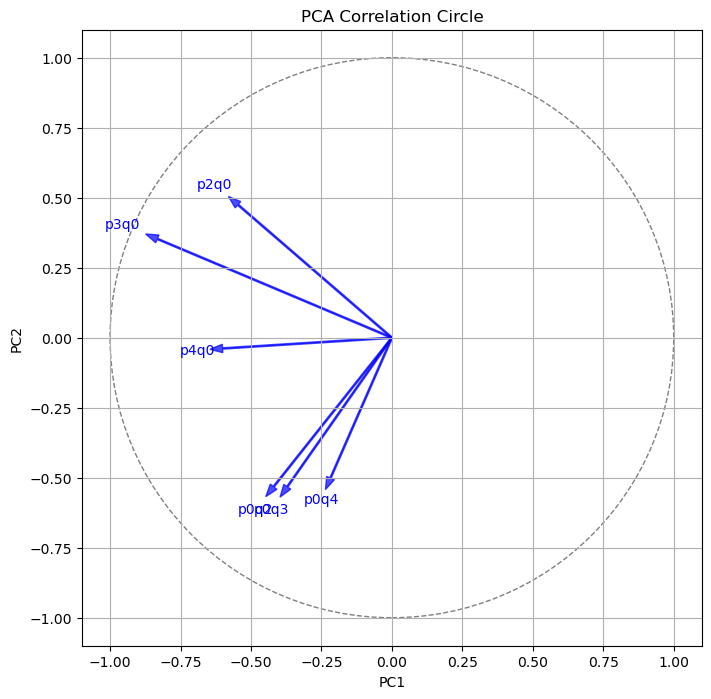

In [20]:
# Create a PCA correlation circle for the original clustering features.
# This plot shows the loadings (contributions) of each feature on the first two principal components.

features = clustering_features
correlations = np.zeros((2, len(features)))

for j in range(len(features)):
    correlations[0, j] = pca.components_[0, j] * np.sqrt(pca.explained_variance_[0])
    correlations[1, j] = pca.components_[1, j] * np.sqrt(pca.explained_variance_[1])

plt.figure(figsize=(8, 8))
# Draw the unit circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Plot each feature as an arrow from the origin
for i, feature in enumerate(features):
    plt.arrow(0, 0, correlations[0, i], correlations[1, i], color='b',
              width=0.005, head_width=0.03, alpha=0.7)
    plt.text(correlations[0, i] * 1.15, correlations[1, i] * 1.15, feature,
             color='b', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Correlation Circle')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid()
plt.show()


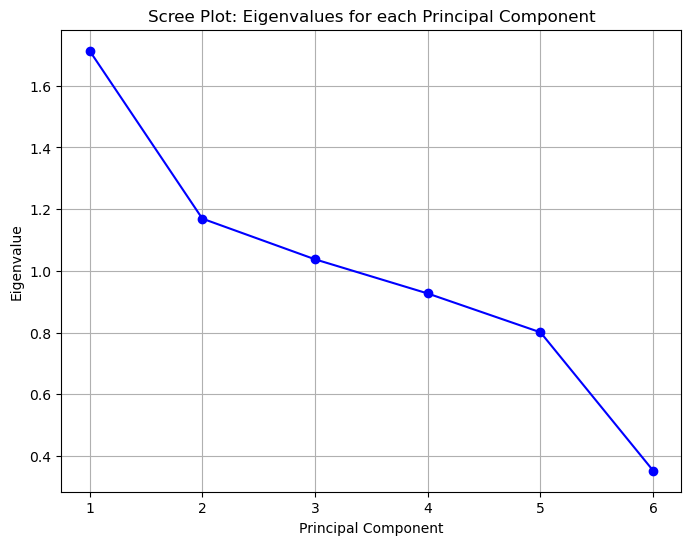

In [21]:
# Compute PCA with all components to inspect eigenvalues
pca_full = PCA()
pca_full.fit(X_scaled)

# Retrieve the eigenvalues
eigenvalues = pca_full.explained_variance_

# Plot the eigenvalues (Scree Plot) to apply the elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-', color='b')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot: Eigenvalues for each Principal Component')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()


Based on the above graphs, we see that only one component can help us segregate the values, therefore wee that there may be 1 outlier in the population

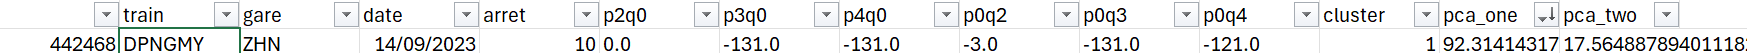

Let's dive a bit more using a one-class SVM

In [ ]:
from sklearn.svm import OneClassSVM

# Extract the first principal component from the PCA results and reshape to a 2D array
pc1 = pca_result[:, 0].reshape(-1, 1)

print("Fitting One-Class SVM on the first principal component...")

# Initialize and fit a One-Class SVM using the first principal component with verbose enabled.
# Here, nu=0.05 suggests we expect about 5% of the data as outliers.
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1, verbose=True)
ocsvm.fit(pc1)

print("SVM training complete.")

# Predict outliers (-1 indicates an outlier, 1 indicates an inlier)
print("Predicting outliers...")
predictions = ocsvm.predict(pc1)

# Add the outlier predictions to the dataframe
df['outlier'] = predictions

# Print the number of detected outliers
num_outliers = (predictions == -1).sum()
print("Number of outliers detected:", num_outliers)

# Plot the first principal component with outliers highlighted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(pc1)), pc1, c=(predictions == -1), cmap='coolwarm', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("First Principal Component (PC1)")
plt.title("Outlier Detection using One-Class SVM on PC1")
plt.colorbar(label="Outlier (True=1)")  # Outliers are marked as True (or 1) in the color map
plt.show()

Fitting One-Class SVM on the first principal component...
[LibSVM]